In [247]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patheffects as pe
import re
from utils import *

#*----------------------------------------------------------------
mpl.rcParams['font.sans-serif'] = ['SimHei'] # *允许显示中文
plt.rcParams['axes.unicode_minus']=False# *允许显示坐标轴负数
#*----------------------------------------------------------------

params = {'legend.fontsize': 7,}

plt.rcParams.update(params)

In [248]:
# dataloader
root = './data'
acc = [0.97063 , 0.97842 ,  0.98512 , 0.98792 , 0.98906 , 0.99028]
input_y = pd.read_csv(root + '/input_Y.csv')
p = input_y['Flooded'].value_counts()[1]/len(input_y) # 该地区中被淹了的建筑比例
n_data = len(input_y) ; index = np.arange(n_data)
p

0.023927633498686898

需要

$Y ,  \hat Y , \hat Y_{unlabeled}$

下面是抽了50次，每次对应的golden-standard的长度是n，对应的unlabeled的长度是N



In [249]:
times = 50 # resampling times
n = 150
N = 8000
index_csv = pd.DataFrame(columns = ['Y_index' , 'Y_hat_index' , 'Y_unlabeled_index'])
for i in range(times):
    Y_index = np.random.choice(index , n , replace=False) # 抽出n个原始数据Y对应的index
    Y_index.sort()
    left = np.setdiff1d(index , Y_index)
    Y_unlabeled_index = np.random.choice(left , N , replace=  False) # 抽取N个 unlabeled对应的Y_hat
    Y_unlabeled_index.sort()
    index_csv.loc[len(index_csv)] = [Y_index ,Y_index ,Y_unlabeled_index]
#index_csv.to_csv('./gdata/index.csv' , index = False)

In [250]:
def eval(text):
    numlist = re.findall(r"\d+\.?\d*", text)
    return [int(n) for n in numlist]
index_csv = pd.read_csv('./gdata/index.csv')
index_csv['Y_index'] = index_csv['Y_index'].apply(eval)
index_csv['Y_hat_index'] = index_csv['Y_hat_index'].apply(eval)
index_csv['Y_unlabeled_index'] = index_csv['Y_unlabeled_index'].apply(eval)

In [251]:
sub_dir = ['/Y_hat_' + (str(i)+'.csv') for i in acc]
data_list = []
ALPHA = 0.1
for i in sub_dir:
    data_list.append(pd.read_csv(root + i))
ppi_df_list = []
for data in data_list:
    ppi_df = pd.DataFrame(columns = ['n' , 'N' , 'lower' , 'upper'])
    for i in range(times):
        index_list = index_csv.iloc[i,:]
        Y = input_y.loc[index_list['Y_index'], 'Flooded'].to_numpy()
        Y_hat = data.loc[index_list['Y_hat_index'], 'Flooded'].to_numpy()
        Y_unlabeled_hat = data.loc[index_list['Y_unlabeled_index'] , 'Flooded'].to_numpy()
        ppi_ci = ppi_mean_ci( Y,Y_hat , Y_unlabeled_hat , alpha = ALPHA)
        ppi_df.loc[len(ppi_df)] = [n , N , ppi_ci[0] , ppi_ci[1]]
    ppi_df['width'] = ppi_df['upper'] - ppi_df['lower']
    ppi_df_list.append(ppi_df)

classical_df =pd.DataFrame(columns = ['n', 'lower' , 'upper'])
for i in range(times): 
    index_list = index_csv.iloc[i,:]
    Y = input_y.loc[index_list['Y_index'], 'Flooded'].to_numpy()
    ci = classical_mean_ci(Y , alpha = ALPHA)
    classical_df.loc[len(classical_df)] = [n , ci[0] , ci[1]]
classical_df['width'] = classical_df['upper'] - classical_df['lower']

In [252]:
def interval_plt(ax , lower,upper,height,
    color_face,color_stroke,
    linewidth=5,linewidth_modifier=1.1,offset=0.25,):
    ax.plot(
            [lower , upper] , [height , height] , color = color_face , 
            path_effects=[
            pe.Stroke(
                linewidth=linewidth * linewidth_modifier,
                offset=(-offset, 0),
                foreground=color_stroke,
            ),
            pe.Stroke(
                linewidth=linewidth * linewidth_modifier,
                offset=(offset, 0),
                foreground=color_stroke,
            ),
            pe.Normal()],)
def CI_summary_plt(axes , CI_df , classical_CI_df):
    hit_index = (CI_df['lower']<=p) & (CI_df['upper']>=p)
    hit_rate = len(CI_df.loc[hit_index])/len(CI_df)   # 区间包含真值的比例
    
    clas_hit_index = (classical_CI_df['lower']<=p) & (classical_CI_df['upper']>=p)
    clas_hit_rate = len(classical_CI_df.loc[hit_index])/len(classical_CI_df)
    
    for i in range(len(CI_df)):
        interval_plt(axes[0] , CI_df.loc[i , 'lower'],CI_df.loc[i , 'upper'], i+1 , 
                        color_face = '#DAF3DA' , color_stroke= '#71D26F')
        interval_plt(axes[1] , classical_CI_df.loc[i , 'lower'],classical_CI_df.loc[i , 'upper'], i+1 , 
                        color_face = '#EEEDED' , color_stroke= '#BFB9B9')
        
        
    axes[0].axvline(p , alpha = 0.5)
    axes[0].set_title('acc = ' + str(acc[index]))
    axes[0].text(0  ,0 ,  s = 'hit rate = ' + str(hit_rate), alpha = 0.9 , size = 8)
    
    axes[1].axvline(p , alpha = 0.5)
    axes[1].set_title('classical CI')
    axes[1].text(0  ,0 ,  s = 'hit rate = ' + str(clas_hit_rate), alpha = 0.9 , size = 8)
    
    axes[2].plot(range(len(CI_df)) , CI_df['width'] , color = '#71D26F')
    axes[2].plot(range(len(classical_CI_df)) , classical_CI_df['width'] , color = '#BFB9B9')
    axes[2].set_title('CI width')
    axes[2].set_xlabel('times') ; axes[2].set_ylabel('width')

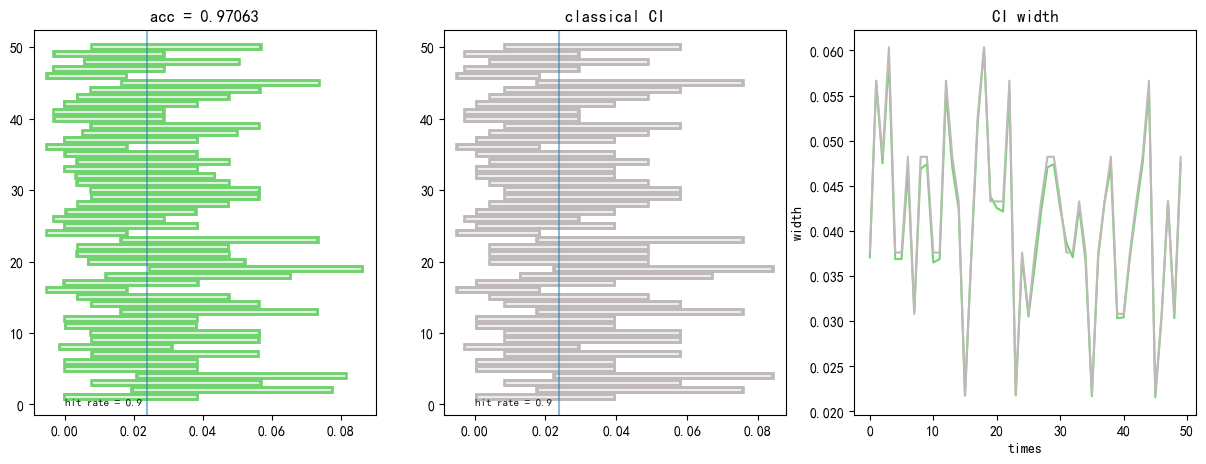

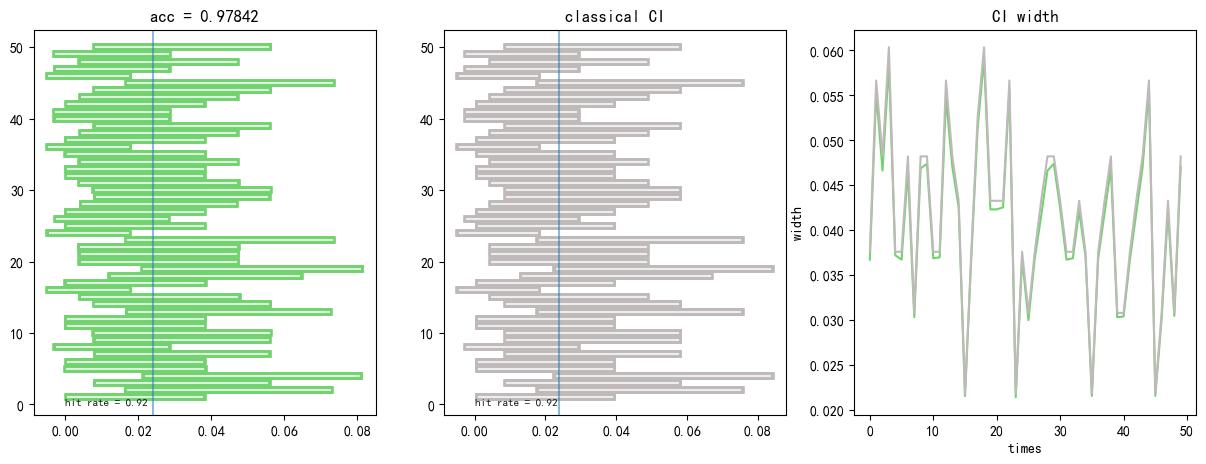

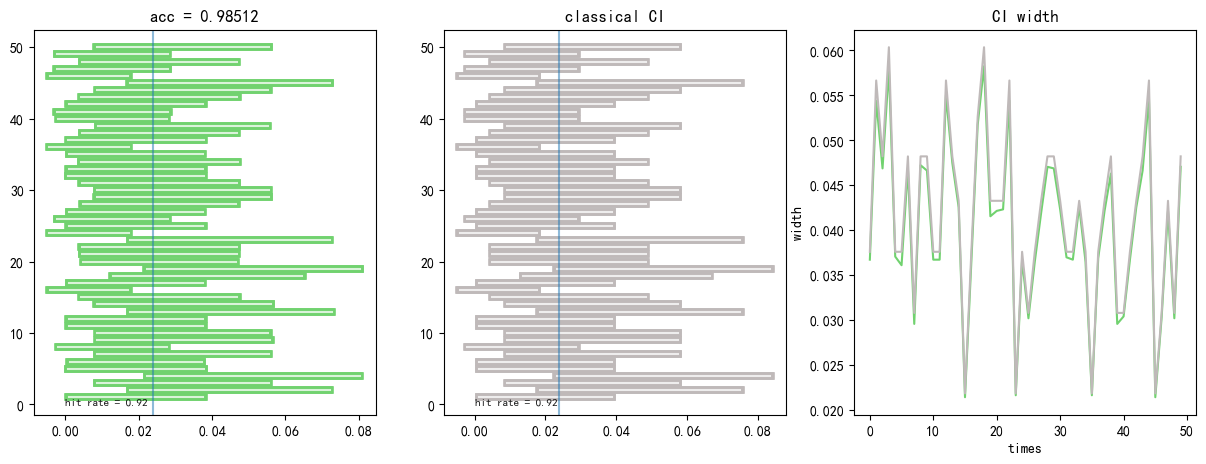

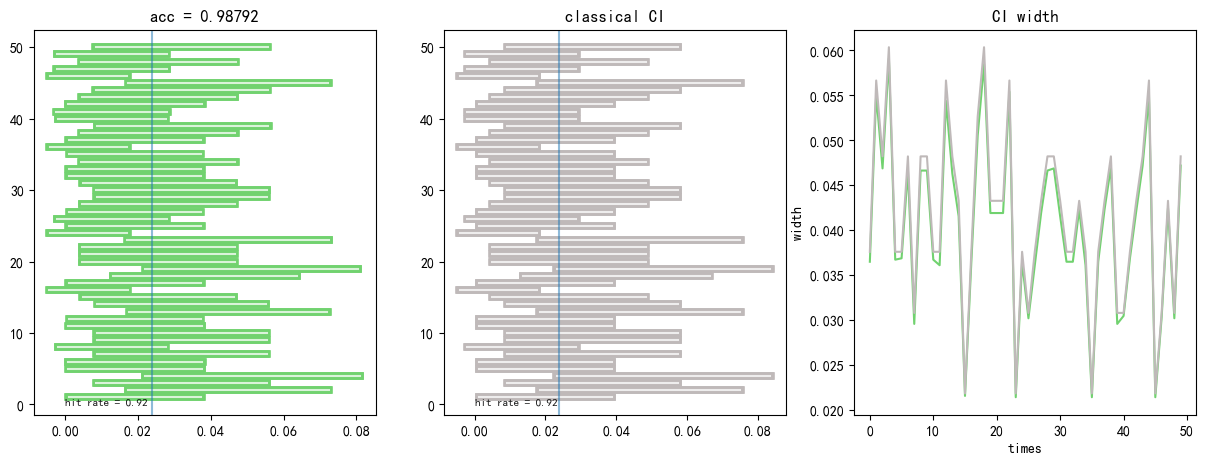

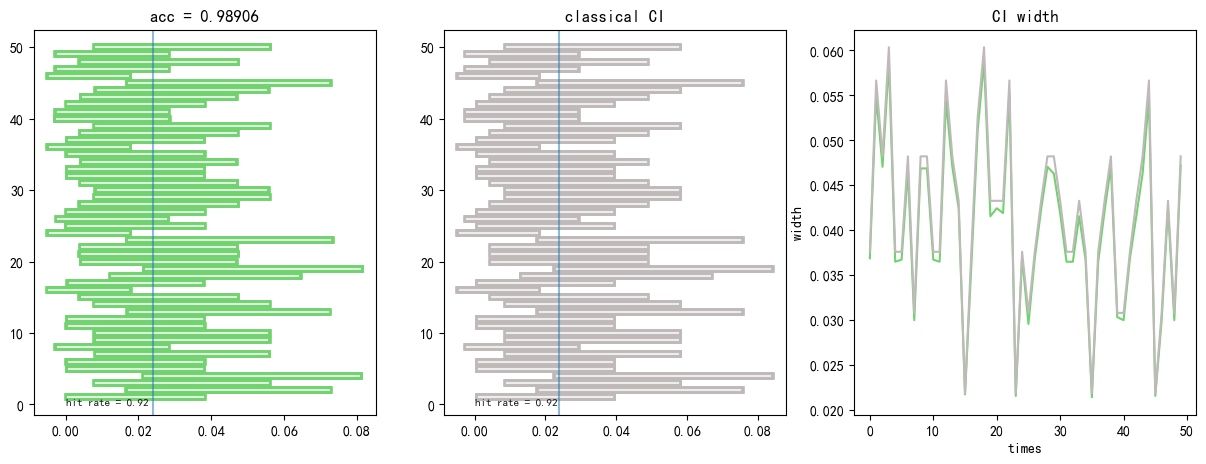

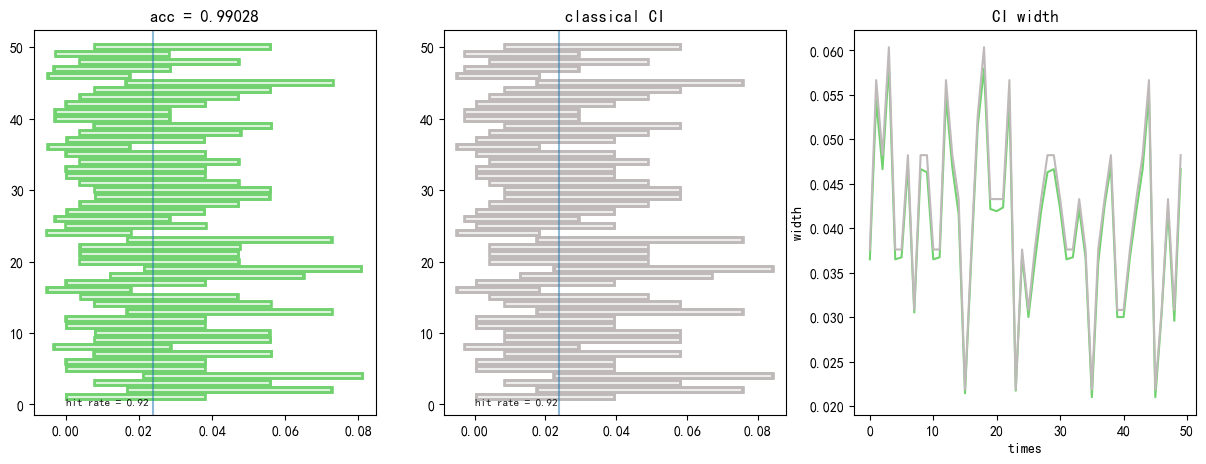

In [253]:
for index , df in enumerate(ppi_df_list):
    fig , axes = plt.subplots(1 , 3 , figsize = (15 , 5) , dpi = 100)
    CI_summary_plt(axes , df , classical_df)

参数说明：此处n为已经人为标注过的数据的样本量，N为未经人为标注过的数据的样本量，显著性水平取0.1

观察置信区间宽度与准确率acc之间的关系可以看到，随着acc增大，在同样的n和N的情况下，宽度会有所减少，意味着更加精准（因为从原理上讲，PPI得到的参数估计是无偏的）

当然，可以遇见的是，由于本身精度变化不大并且Flooded的房屋的总体比例p是一个很小的数字（0.02392），所以并不会呈现十分显著的区别，有待后续实验选取更低的acc进行下一步验证。